# T81-558: Applications of Deep Neural Networks
**Class 4: Classification and Regression**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Binary Classification, Classification and Regression

* **Binary Classification** - Classification between two possibilities (positive and negative).  Common in medical testing, does the person have the disease (positive) or not (negative).
* **Classification** - Classification between more than 2.  The iris dataset (3-way classification).
* **Regression** - Numeric prediction.  How many MPG does a car get?

In this class session we will look at some visualizations for all three.


# Feature Vector Encoding

These are exactly the same feature vector encoding functions from [Class 3](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class3_training.ipynb).  They must be defined for this class as well.  For more information, refer to class 3.

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the origional column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df,name,target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x)==str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name,tv)
        df[name2] = l
    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart, we will see more of this chart in the next class.
def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred, 'y' : y_test.flatten()})
    t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Get a new directory to hold checkpoints from a neural network.  This allows the neural network to be
# loaded later.  If the erase param is set to true, the contents of the directory will be cleared.
def get_model_dir(name,erase):
    base_path = os.path.join(".","dnn")
    model_dir = os.path.join(base_path,name)
    os.makedirs(model_dir,exist_ok=True)
    if erase and len(model_dir)>4 and os.path.isdir(model_dir):
        shutil.rmtree(model_dir,ignore_errors=True) # be careful, this deletes everything below the specified path
    return model_dir

# Toolkit: Visualization Functions

This class will introduce 3 different visualizations that can be used with the two different classification type neural networks and regression neural networks.

* **Confusion Matrix** - For any type of classification neural network.
* **ROC Curve** - For binary classification.
* **Lift Curve** - For regression neural networks.

The code used to produce these visualizations is shown here:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y_test, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Binary Classification


Binary classification is used to create a model that classifies between only two classes.  These two classes are often called "positive" and "negative".  Consider the following program that uses the [wcbreast_wdbc dataset](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/datasets_wcbc.ipynb) to classify if a breast tumor is cancerous (malignant) or not (benign).  The iris dataset is not binary, because there are three classes (3 types of iris).


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.contrib.learn as learn
import numpy as np
from sklearn import metrics

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"
    
filename = os.path.join(path,"wcbreast_wdbc.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

# Encode feature vector
df.drop('id',axis=1,inplace=True)
encode_numeric_zscore(df,'mean_radius')
encode_numeric_zscore(df,'mean_texture')   
encode_numeric_zscore(df,'mean_perimeter')
encode_numeric_zscore(df,'mean_area')
encode_numeric_zscore(df,'mean_smoothness')
encode_numeric_zscore(df,'mean_compactness')
encode_numeric_zscore(df,'mean_concavity')
encode_numeric_zscore(df,'mean_concave_points')
encode_numeric_zscore(df,'mean_symmetry')
encode_numeric_zscore(df,'mean_fractal_dimension')
encode_numeric_zscore(df,'se_radius')
encode_numeric_zscore(df,'se_texture')
encode_numeric_zscore(df,'se_perimeter')
encode_numeric_zscore(df,'se_area')
encode_numeric_zscore(df,'se_smoothness')
encode_numeric_zscore(df,'se_compactness')
encode_numeric_zscore(df,'se_concavity')
encode_numeric_zscore(df,'se_concave_points')
encode_numeric_zscore(df,'se_symmetry')
encode_numeric_zscore(df,'se_fractal_dimension')
encode_numeric_zscore(df,'worst_radius')
encode_numeric_zscore(df,'worst_texture')
encode_numeric_zscore(df,'worst_perimeter')
encode_numeric_zscore(df,'worst_area')
encode_numeric_zscore(df,'worst_smoothness')
encode_numeric_zscore(df,'worst_compactness')
encode_numeric_zscore(df,'worst_concavity')
encode_numeric_zscore(df,'worst_concave_points')
encode_numeric_zscore(df,'worst_symmetry')
encode_numeric_zscore(df,'worst_fractal_dimension')
diagnosis = encode_text_index(df,'diagnosis')
num_classes = len(diagnosis)

# Create x & y for training

# Create the x-side (feature vectors) of the training
x, y = to_xy(df,'diagnosis')
    
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42) 
    
# Get/clear a directory to store the neural network to
model_dir = get_model_dir('wcbreast',True)

# Create a deep neural network with 3 hidden layers of 10, 20, 5
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
classifier = learn.DNNClassifier(
    model_dir= model_dir,
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    hidden_units=[10, 20, 5], n_classes=num_classes, feature_columns=feature_columns)

# Might be needed in future versions of "TensorFlow Learn"
#classifier = learn.SKCompat(classifier) # For Sklearn compatibility

# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=50,
    #metrics=validation_metrics,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=500)
    
# Fit/train neural network
classifier.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

# Measure accuracy
pred = list(classifier.predict(x_test, as_iterable=True))
score = metrics.accuracy_score(y_test, pred)
print("Final accuracy: {}".format(score))


### Confusion Matrix

The confusion matrix is a common visualization for both binary and larger classification problems.  Often a model will have difficulty differentiating between two classes.  For example, a neural network might be really good at telling the difference between cats and dogs, but not so good at telling the difference between dogs and wolves.  The following code generates a confusion matrix:

Confusion matrix, without normalization
[[71 18]
 [ 4 50]]
Normalized confusion matrix
[[ 0.8   0.2 ]
 [ 0.07  0.93]]


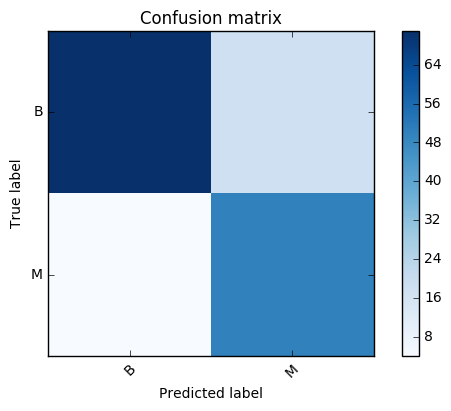

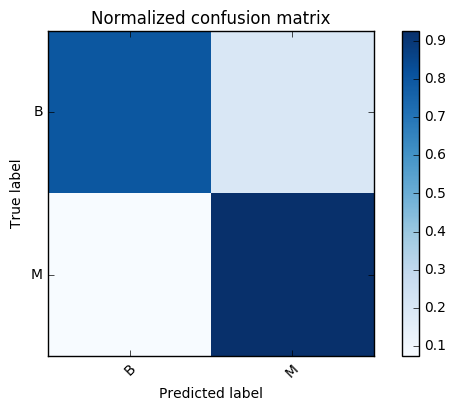

In [16]:
import numpy as np

from sklearn import svm, datasets
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, diagnosis)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, diagnosis, title='Normalized confusion matrix')

plt.show()

The above two confusion matrixes show the same network.  The bottom (normalized) is the type you will normally see.  Notice the two labels.  The label "B" means benign (no cancer) and the label "M" means malignant (cancer).  The left-right (x) axis are the predictions, the top-bottom) are the expected outcomes.  A perfect model (that never makes an error) has a dark blue diagonal that runs from top-left to bottom-right.  

To read, consider the top-left square.  This square indicates "true labeled" of B and also "predicted label" of B.  This is good! The prediction matched the truth.  The blueness of this box represents how often "B" is classified correct.  It is not darkest blue.  This is because the square to the right(which is off the perfect diagonal) has some color.  This square indicates truth of "B" but prediction of "M". The white square, at the bottom-left, indicates a true of "M" but predicted of "B".  The whiteness indicates this rarely happens.  

Your conclusion from the above chart is that the model sometimes classifies "B" as "M" (a false negative), but never mis-classifis "M" as "B".  Always look for the dark diagonal, this is good!

### ROC Curves

ROC curves can be a bit confusing.  However, they are very common.  It is important to know how to read them.  Even their name is confusing.  Do not worry about their name, it comes from electrical engineering (EE).

Binary classification is common in medical testing.  Often you want to diagnose if someone has a disease.  This can lead to two types of errors, know as false positives and false negatives:

* **False Positive** - Your test (neural network) indicated that the patient had the disease; however, the patient did not have the disease.
* **False Negative** - Your test (neural network) indicated that the patient did not have the disease; however, the patient did have the disease.
* **True Positive** - Your test (neural network) correctly identified that the patient had the disease.
* **True Negative** - Your test (neural network) correctly identified that the patient did not have the disease.

Types of errors:

![Type of Error](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_4_errors.png "Type of Error")

Neural networks classify in terms of probbility of it being positive. However, at what probability do you give a positive result?  Is the cutoff 50%? 90%?  Where you set this cutoff is called the threshold.  Anything above the cutoff is positive, anything below is negative.  Setting this cutoff allows the model to be more sensative or specific:

![Sensitivity vs. Specificity](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_4_t1vst2.png "Sensitivity vs. Specificity")

The following shows a more sensitive cutoff:

![Sensitive Cutoff ](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_4_spec_cut.png "Sensitive Cutoff")

**An ROC curve measures how good a model is regardless of the cutoff.** The following shows how to read a ROC chart:


![Reading a ROC Chart](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_4_roc.png "Reading a ROC Chart")

The following code shows an ROC chart for the breast cancer neural network.  The area under the curve (AUC) is also an important measure.  The larger the AUC, the better.

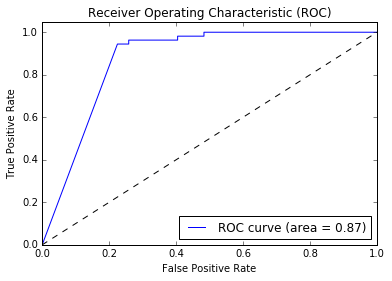

In [10]:
pred = classifier.predict_proba(x_test)
pred = pred[:,1] # Only positive cases
# print(pred[:,1])
plot_roc(pred,y_test)


# Classification

We've already seen multi-class classification, with the iris dataset.  Confusion matrixes work just fine with 3 classes.  The following code generates a confusion matrix for iris.

In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow.contrib.learn as learn
import tensorflow as tf
import numpy as np

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.INFO)

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

# Encode feature vector
encode_numeric_zscore(df,'petal_w')
encode_numeric_zscore(df,'petal_l')
encode_numeric_zscore(df,'sepal_w')
encode_numeric_zscore(df,'sepal_l')
species = encode_text_index(df,"species")
num_classes = len(species)

# Create x & y for training

# Create the x-side (feature vectors) of the training
x, y = to_xy(df,'species')
    
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45) 
    # as much as I would like to use 42, it gives a perfect result, and a boring confusion matrix!
    
# Get/clear a directory to store the neural network to
model_dir = get_model_dir('iris',True)

# Create a deep neural network with 3 hidden layers of 10, 20, 5
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
classifier = learn.DNNClassifier(
    model_dir= model_dir,
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    hidden_units=[10, 20, 5], n_classes=num_classes, feature_columns=feature_columns)

# Might be needed in future versions of "TensorFlow Learn"
#classifier = learn.SKCompat(classifier) # For Sklearn compatibility

# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=500,
    #metrics=validation_metrics,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=50)
    
# Fit/train neural network
classifier.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)



INFO:tensorflow:Using config: {'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'keep_checkpoint_every_n_hours': 10000, '_is_chief': True, 'save_checkpoints_secs': 1, '_evaluation_master': '', 'tf_random_seed': None, '_environment': 'local', '_task_type': None, '_task_id': 0, '_master': '', '_num_ps_replicas': 0, 'save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B7845B8D68>, 'keep_checkpoint_max': 5, 'save_checkpoints_steps': None}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving in

Confusion matrix, without normalization
[[14  0  0]
 [ 0  9  0]
 [ 0  2 13]]
Normalized confusion matrix
[[ 1.    0.    0.  ]
 [ 0.    1.    0.  ]
 [ 0.    0.13  0.87]]


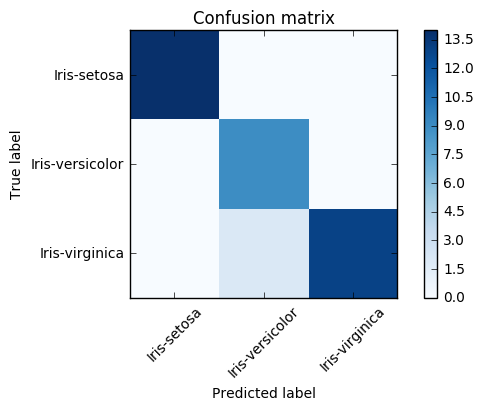

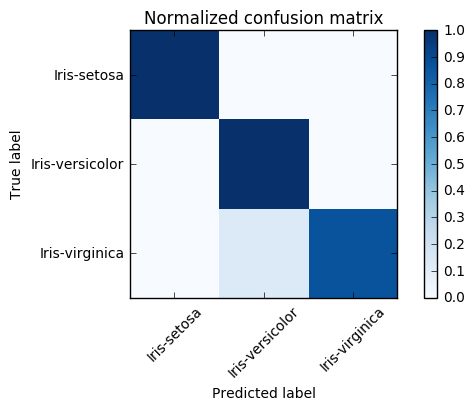

In [9]:
import numpy as np

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

pred = list(classifier.predict(x_test, as_iterable=True))
    
# Compute confusion matrix
cm = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, species)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, species, title='Normalized confusion matrix')

plt.show()

See the strong diagonal?  Iris is easy.  See the light blue near the bottom?  Sometimes virginica is confused for versicolor.

# Regression

We've already seen regression with the MPG dataset.  Regression uses its own set of visualizations, one of the most common is the lift chart.  The following code generates a lift chart.

In [11]:
import tensorflow.contrib.learn as learn
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn import metrics
from scipy.stats import zscore

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.INFO)

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('mpg',True)

# Create a deep neural network with 3 hidden layers of 50, 25, 10
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = learn.DNNRegressor(
    model_dir= model_dir,
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    feature_columns=feature_columns,
    hidden_units=[50, 25, 10])

# Might be needed in future versions of "TensorFlow Learn"
#classifier = learn.SKCompat(classifier) # For Sklearn compatibility

# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=500,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=50)
    
# Fit/train neural network
regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

INFO:tensorflow:Using config: {'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, 'keep_checkpoint_every_n_hours': 10000, '_is_chief': True, 'save_checkpoints_secs': 1, '_evaluation_master': '', 'tf_random_seed': None, '_environment': 'local', '_task_type': None, '_task_id': 0, '_master': '', '_num_ps_replicas': 0, 'save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001B786D4A4A8>, 'keep_checkpoint_max': 5, 'save_checkpoints_steps': None}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving in

DNNRegressor(hidden_units=[50, 25, 10], dropout=None, feature_columns=[_RealValuedColumn(column_name='', dimension=398, default_value=None, dtype=tf.float32, normalizer=None)], optimizer=None)

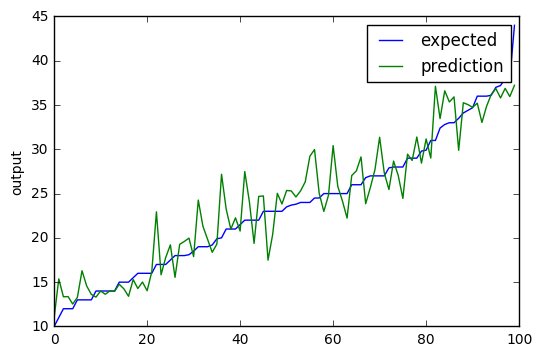

In [16]:
# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

pred = list(regressor.predict(x_test, as_iterable=True))

chart_regression(pred,y_test)

To generate a lift chart, perform the following activities:

* Sort the data by expected output.  Plot the blue line above.
* For every point on the x-axis plot the predicted value for that same data point.  This is the green line above.
* The x-axis is just 0 to 100% of the dataset.  The expected always starts low and ends high.
* The y-axis is ranged according to the values predicted.

Reading a lift chart:
* The expected and predict lines should be close.  Notice where one is above the ot other.
* The above chart is the most accurate on lower MPG.